In [1]:
# install packages
! pip install networkx==3.1
! pip install nxviz==0.7.3
! pip install pyvis==0.3.1

# load environment
from networkx.algorithms.community import louvain_communities, modularity

import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import random
import scipy
import statistics

# set seed
np.random.seed(611)
random.seed(611)
random_state = np.random.RandomState(611)


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
# define universal variables
CUTOFF_EFFECT_SIZE = 0.3
GROUP = 'control'
N_CORRELATIONS = 16851765  # interomics correlations only
#N_CORRELATIONS = 63286875  # intra + interomics correlations
RESOLUTION = 0.45
SEED = 611

DTYPE_MAPPING={
    'col1': 'str',
    'name1': 'str',
    'type1': 'str',
    'supergroup1': 'str',
    'subgroup1': 'str',
    'col2': 'str', 
    'name2': 'str',
    'type2': 'str',
    'supergroup2': 'str',
    'subgroup2': 'str',
    'coef': 'float',
    'p-value': 'float',
    'pval_adj' : 'float'
}

In [3]:
# define functions
def determine_edge_color(value):
    if value > 0:
        return 'royalblue'
    if value < 0:
        return 'crimson'
    return 'dimgrey'


def define_node_color(type):
    if type == 'metabolite': 
        return 'mediumorchid'
    if type == 'protein':
        return 'seagreen'
    if type == 'transcript':
        return 'cornflowerblue'
    if type == 'histopathology':
        return 'goldenrod'
    return 'dimgrey'


def create_node_type_lists(name, t, list_metabolites, list_proteins, list_transcripts):
    if t == 'metabolite':
        list_metabolites.append(name)
    elif t == 'protein':
        list_proteins.append(name)
    elif t == 'transcript':
        list_transcripts.append(name)
    return(list_metabolites, list_proteins, list_transcripts)


def add_node_info(row, nodes, list_metabolites, list_proteins, list_transcripts):
    if row['name1'] not in nodes:
        nodes.append(row['name1'])
        color = define_node_color(row['type1'])
        list_metabolites, list_proteins, list_transcripts = create_node_type_lists(row['name1'], row['type1'], list_metabolites, list_proteins, list_transcripts)
    if row['name2'] not in nodes:
        nodes.append(row['name2'])
        color = define_node_color(row['type2'])
        list_metabolites, list_proteins, list_transcripts = create_node_type_lists(row['name2'], row['type2'], list_metabolites, list_proteins, list_transcripts)
    return(nodes, list_metabolites, list_proteins, list_transcripts)

    
def add_n_of_x_to_list(l, n, x):
    c = 0
    while c < n:
        l.append(x)
        c += 1
    return l


def print_list(l):
    for item in l:
        print(item)

        
def initialize_dict(l):
    d = {}
    for item in l:
        d[item] = 0
    return d


def limit_to_n_top_correlations_per_group(df, col, list_of_groups, n, ascending=False):
    d = initialize_dict(list_of_groups)
    df_final = pd.DataFrame(columns=df.columns)
    
    df = df.reindex(df[col].abs().sort_values(ascending=ascending).index)
    print('The', col, 'of', str(n), 'top selected nodes:')
    for index, row in df.iterrows():
        type1 = row['type1']
        type2 = row['type2']
        if d[type1] < n or d[type2] < n:
            print(abs(row[col]))
            df_final.loc[len(df_final.index)] = row
            d[type1] += 1
            d[type2] +=1
    print(d)
    return df_final


def calc_partition_quality(G, group):
    list_partition_quality = []
    comm = louvain_communities(G, weight='coef', resolution=RESOLUTION, seed=SEED)
    partition = [list(community) for community in comm]
    quality = nx.community.partition_quality(G, partition)
    print(group + ' Coverage: ' + str(quality[0]))
    print(group + ' Performance: ' + str(quality[1]))
    print('\n')
    return quality


def convert_df_to_graph(df):
    # format data for network
    colormap = {'histopathology': 'goldenrod', 'metabolite': 'mediumorchid', 'miRNA': 'palepink', 'protein': 'seagreen', 'transcript': 'cornflowerblue'}
    dict_edge_color = {}
    dict_edge_weight = {}
    dict_node_type = {}
    dict_nodes_by_type = {'histopathology': [], 'metabolite': [], 'miRNA': [], 'protein': [], 'transcript': []}
    edges = set()
    list_metabolites = []
    list_node_color = []
    list_proteins = []
    list_transcripts = []
    nodes_initial = []
    nodes = []

    for index, row in df.iterrows():
        key = (row['name1'], row['name2'])
        edges.add(key)
        dict_edge_color[key] = determine_edge_color(row['coef'])
        dict_edge_weight[key] = abs(row['coef'])

        nodes_initial, list_metabolites, list_proteins, list_transcripts = add_node_info(row, nodes_initial, list_metabolites, list_proteins, list_transcripts)
        dict_node_type[row['name1']] = row['type1']
        dict_node_type[row['name2']] = row['type2']
        dict_nodes_by_type[row['type1']].append(row['name1'])
        dict_nodes_by_type[row['type2']].append(row['name2'])

        edges.add(key)


    # sort nodes list by type
    for key, value in dict_nodes_by_type.items():
        value = sorted(list(set(value)))    # add alphabetically sorted nodes
        nodes.extend(value)
        color = colormap[key]    # add node color to list
        list_node_color = add_n_of_x_to_list(list_node_color, len(value), color)


    # initiate network
    G = nx.Graph()
    G.add_nodes_from(nodes, node_color=list_node_color)
    nx.set_node_attributes(G, dict_node_type, name="type")
    for edge in edges:
        G.add_edge(*edge, weight=math.sqrt(math.sqrt(dict_edge_weight[edge])), color=dict_edge_color[edge])
    return G

# Tune Effect Size

In [4]:
# load data
df = pd.read_csv('../data/spearman.standardized.interomics.' + GROUP + '.all.miniDP3.txt', sep='\t', dtype=DTYPE_MAPPING)
df = df[df['type1'] != df['type2']]
bonferroni_p = 0.05/N_CORRELATIONS  # bonferroni multiple hypothesis correction
df = df[df['p-value']<bonferroni_p]

In [5]:
# evaluate coverage and performance at different effect size cutoffs
l_effect_size = []
l_coverage = []
l_performance = []

for effect_size in np.arange(0, 1, 0.05):
    df = df[abs(df['coef']) >= effect_size]
    print('Effect Size:', str(effect_size))
    print('Number of significant correlations with effect size greater or equal to '+str(effect_size)+': '+str(df.shape[0]))
    if df.shape[0] == 0:
        print('No significant correlations have this effect size!')
        break
    G = convert_df_to_graph(df)
    coverage, performance = calc_partition_quality(G, 'Control')
    l_effect_size.append(effect_size)
    l_coverage.append(coverage)
    l_performance.append(performance)

Effect Size: 0.0
Number of significant correlations with effect size greater or equal to 0.0: 2267
Control Coverage: 0.948831054256727
Control Performance: 0.7216437916517208


Effect Size: 0.05
Number of significant correlations with effect size greater or equal to 0.05: 2267
Control Coverage: 0.948831054256727
Control Performance: 0.7216437916517208


Effect Size: 0.1
Number of significant correlations with effect size greater or equal to 0.1: 2267
Control Coverage: 0.948831054256727
Control Performance: 0.7216437916517208


Effect Size: 0.15000000000000002
Number of significant correlations with effect size greater or equal to 0.15000000000000002: 2267
Control Coverage: 0.948831054256727
Control Performance: 0.7216437916517208


Effect Size: 0.2
Number of significant correlations with effect size greater or equal to 0.2: 2267
Control Coverage: 0.948831054256727
Control Performance: 0.7216437916517208


Effect Size: 0.25
Number of significant correlations with effect size greater or 

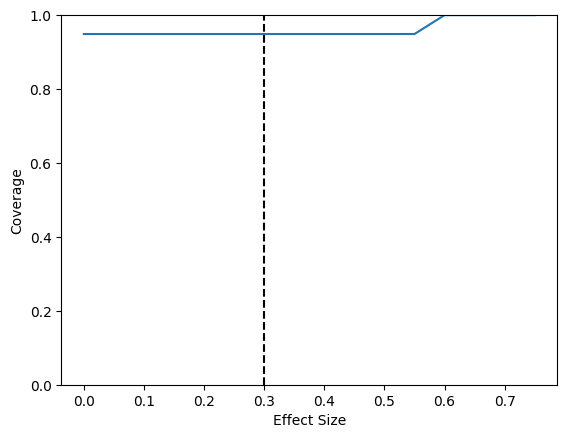

In [6]:
plt.plot(l_effect_size, l_coverage)
plt.xlabel('Effect Size')
plt.axvline(x=CUTOFF_EFFECT_SIZE, color='black', linestyle='dashed')
plt.ylabel('Coverage')
plt.ylim((0,1))
plt.savefig("../output/tuning/"+GROUP+"_louvain_community_effect_size_tuning_control_coverage.pdf", format="pdf", bbox_inches="tight")
plt.show()

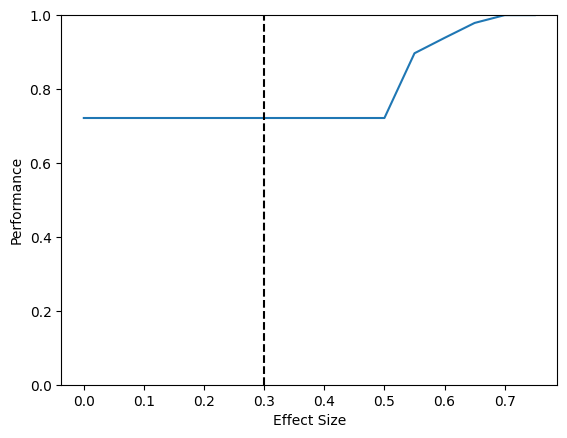

In [7]:
plt.plot(l_effect_size, l_performance)
plt.xlabel('Effect Size')
plt.ylabel('Performance')
plt.axvline(x=CUTOFF_EFFECT_SIZE, color='black', linestyle='dashed')
plt.ylim((0,1))
plt.savefig("../output/tuning/"+GROUP+"_louvain_community_effect_size_tuning_control_performance.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Tune Resolution

In [8]:
# load data
df = pd.read_csv('../data/spearman.standardized.interomics.' + GROUP + '.all.miniDP3.txt', sep='\t', dtype=DTYPE_MAPPING)
df = df[df['type1'] != df['type2']]
bonferroni_p = 0.05/N_CORRELATIONS  # bonferroni multiple hypothesis correction
df = df[df['p-value']<bonferroni_p]
df = df[abs(df['coef']) >= CUTOFF_EFFECT_SIZE]

In [9]:
# format data for network
colormap = {'histopathology': 'goldenrod', 'metabolite': 'mediumorchid', 'miRNA': 'palepink', 'protein': 'seagreen', 'transcript': 'cornflowerblue'}
dict_edge_color = {}
dict_edge_weight = {}
dict_node_type = {}
dict_nodes_by_type = {'histopathology': [], 'metabolite': [], 'miRNA': [], 'protein': [], 'transcript': []}
edges = set()
list_metabolites = []
list_node_color = []
list_proteins = []
list_transcripts = []
nodes_initial = []
nodes = []

for index, row in df.iterrows():
    key = (row['name1'], row['name2'])
    edges.add(key)
    dict_edge_color[key] = determine_edge_color(row['coef'])
    dict_edge_weight[key] = abs(row['coef'])
    
    nodes_initial, list_metabolites, list_proteins, list_transcripts = add_node_info(row, nodes_initial, list_metabolites, list_proteins, list_transcripts)
    dict_node_type[row['name1']] = row['type1']
    dict_node_type[row['name2']] = row['type2']
    dict_nodes_by_type[row['type1']].append(row['name1'])
    dict_nodes_by_type[row['type2']].append(row['name2'])
    
    edges.add(key)

    
# sort nodes list by type
for key, value in dict_nodes_by_type.items():
    value = sorted(list(set(value)))    # add alphabetically sorted nodes
    nodes.extend(value)
    color = colormap[key]    # add node color to list
    list_node_color = add_n_of_x_to_list(list_node_color, len(value), color)
    
    
# initiate network
G = nx.Graph()
G.add_nodes_from(nodes, node_color=list_node_color)
nx.set_node_attributes(G, dict_node_type, name="type")
for edge in edges:
    G.add_edge(*edge, weight=math.sqrt(math.sqrt(dict_edge_weight[edge])), color=dict_edge_color[edge])

print('Number of Nodes:', str(len(nodes)))
print('Number of Edges:', str(len(edges)))

Number of Nodes: 1137
Number of Edges: 2267


In [10]:
l_res = []
l_mod = []
l_comm_size = []

for resolution in np.arange(0.05, 2, 0.05):
    comm = louvain_communities(G, weight='coef', resolution=resolution, seed=SEED)
    mod = modularity(G, comm, weight='coef', resolution=resolution)
    l_res.append(resolution)
    l_mod.append(mod)
    l_comm_size.append(len(comm))

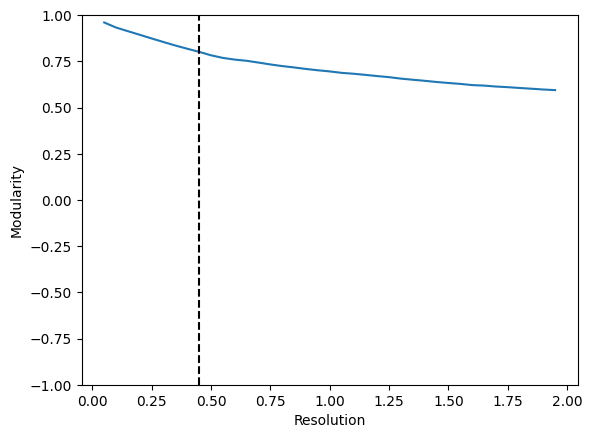

In [11]:
plt.plot(l_res, l_mod)
plt.xlabel('Resolution')
plt.ylabel('Modularity')
plt.axvline(x=RESOLUTION, color='black', linestyle='dashed')
plt.ylim((-1,1))
plt.savefig("../output/tuning/"+GROUP+"_louvain_community_resolution_tuning_control_modularity.pdf", format="pdf", bbox_inches="tight")
plt.show()

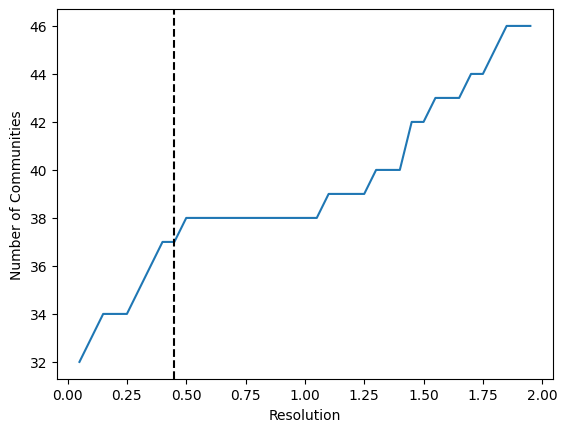

In [12]:
plt.plot(l_res, l_comm_size)
plt.xlabel('Resolution')
plt.ylabel('Number of Communities')
plt.axvline(x=RESOLUTION, color='black', linestyle='dashed')
plt.savefig("../output/tuning/"+GROUP+"_louvain_community_resolution_tuning_control_comm_size.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [13]:
comm = louvain_communities(G, weight='coef', resolution=RESOLUTION, seed=SEED)
print('Modularity:', str(round(modularity(G, comm, weight='coef', resolution=RESOLUTION),2)))
print('Number of Communities:', str(len(comm)))

Modularity: 0.8
Number of Communities: 37


In [14]:
df.shape[0]

2267